In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [176]:
plt.rcParams["figure.figsize"] = (14,4)

In [177]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])
data = data.drop(columns=["Unnamed: 0", "nro factura"])

In [178]:
u_producto = data.groupby(["tiempo", "producto"])["u pedidas"].sum().unstack().asfreq("D").fillna(0)

In [179]:
amount_info = (u_producto != 0).sum() / len(u_producto)
T = 0.5
forecastable = (amount_info > T)

In [180]:
forecastable = u_producto.loc[:, forecastable]

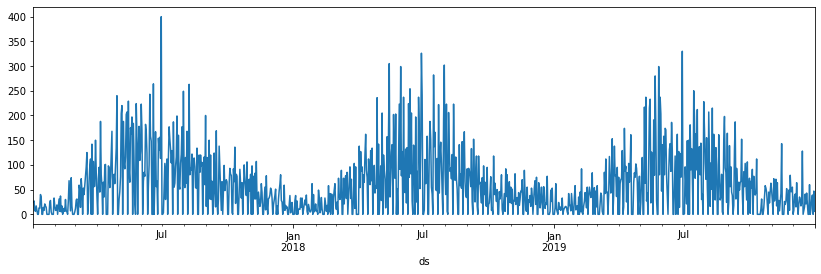

In [181]:
target = forecastable[16070].copy()
target.index.name = "ds"
target.name = "y"
target.plot()

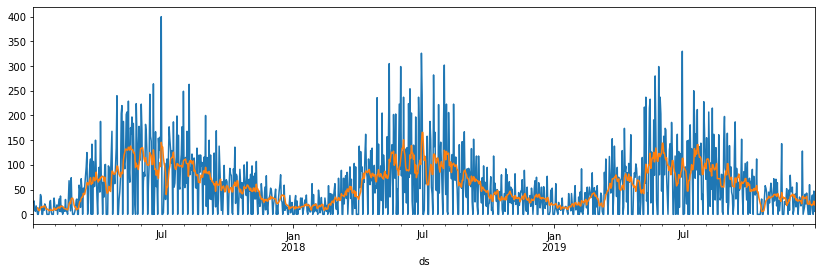

In [182]:
rolling_mean = target.rolling(window=7).mean()
target.plot()
rolling_mean.plot();

In [183]:
target_filled = target.copy()
target_filled[target == 0] = rolling_mean[target == 0]
target = target[target != 0]

In [184]:
#train, test = target[:"2018-12-31"], target["2019-01-01":]

In [185]:
train, test = target_filled[:"2018-12-31"], target_filled["2019-01-01":]

# TBATS

In [66]:
from tbats import TBATS, BATS

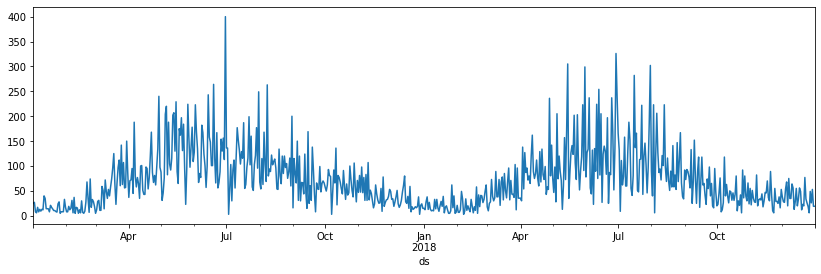

In [119]:
train.plot()

In [152]:
tbats = TBATS(
    use_box_cox=True,
    use_trend=False,
    use_damped_trend=False,
    use_arma_errors=True,
    seasonal_periods=(365.25,),
)

In [153]:
model = tbats.fit(train)

In [154]:
fcst = model.forecast(steps=365)

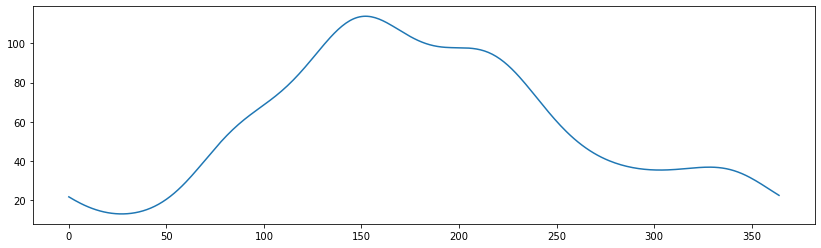

In [155]:
plt.plot(fcst)

In [158]:
fcst = pd.Series(fcst, index=pd.date_range(start="2019-01-01", end="2019-12-31", freq="D"))

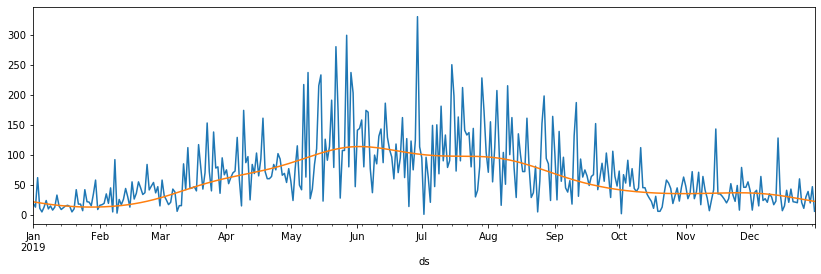

In [159]:
test.plot()
fcst.plot()

In [107]:
bats = BATS(
    use_box_cox=True,
    use_trend=False,
    use_damped_trend=False,
    use_arma_errors=False,
    seasonal_periods=(365,),
)

In [108]:
model = bats.fit(train)

In [109]:
fcst = model.forecast(steps=365)

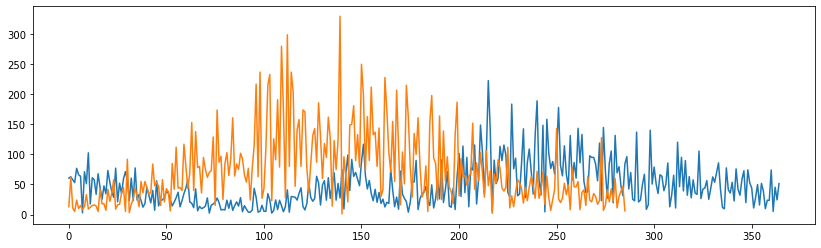

In [111]:
plt.plot(fcst)
plt.plot(test.to_numpy())

In [161]:
import pmdarima as pm

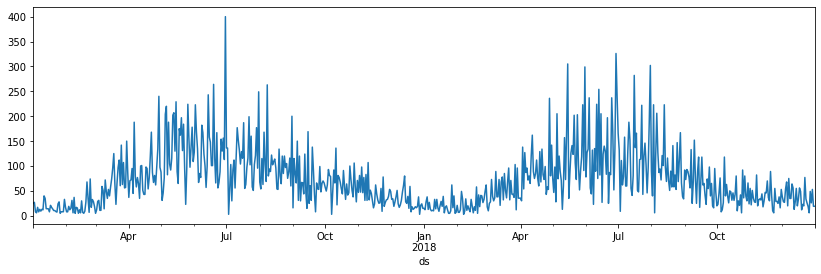

In [163]:
train.plot()

In [186]:
train_m = train.resample("M").sum()

In [188]:
test_m = test.resample("M").sum()

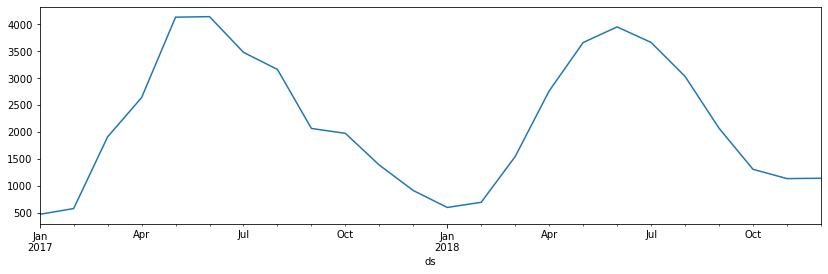

In [189]:
train_m.plot()

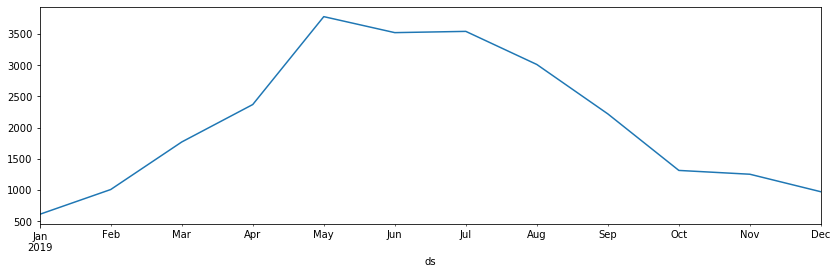

In [190]:
test_m.plot()

In [195]:
train_m

ds
2017-01-31     467.571429
2017-02-28     574.714286
2017-03-31    1908.000000
2017-04-30    2637.142857
2017-05-31    4132.428571
2017-06-30    4142.428571
2017-07-31    3479.000000
2017-08-31    3160.571429
2017-09-30    2063.857143
2017-10-31    1972.571429
2017-11-30    1382.285714
2017-12-31     909.571429
2018-01-31     595.000000
2018-02-28     691.571429
2018-03-31    1542.142857
2018-04-30    2761.857143
2018-05-31    3661.000000
2018-06-30    3951.428571
2018-07-31    3663.142857
2018-08-31    3031.857143
2018-09-30    2068.857143
2018-10-31    1304.428571
2018-11-30    1131.714286
2018-12-31    1137.714286
Freq: M, Name: y, dtype: float64

In [201]:
target

ds
2017-01-02    25.0
2017-01-03    27.0
2017-01-04     8.0
2017-01-05     6.0
2017-01-06    17.0
              ... 
2019-12-26    11.0
2019-12-27    30.0
2019-12-28    39.0
2019-12-30    47.0
2019-12-31     6.0
Name: y, Length: 863, dtype: float64

In [206]:
target_m = target.resample("M").sum()

In [212]:
target_w = target.resample("W").sum()

In [213]:
fit = pm.auto_arima(target_w, m=52, seasonal=True)

/home/ariel/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/ariel/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ariel/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ariel/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/ariel/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ariel/anaconda3/en

In [214]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  157
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -972.101
Date:                            Fri, 06 Mar 2020   AIC                           1956.201
Time:                                    17:18:23   BIC                           1974.539
Sample:                                         0   HQIC                          1963.649
                                            - 157                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.4064      9.518      2.249      0.025       2.752      40.061
ar.L1          0.3739      0.069      5.441      0.000       0.239       0.509
ar.L2          0.3668      0.070      5.203      0.000       0.229       0.505
ar.S.L52       0.3657      0.086      4.261      0.000       0.197       0.534
ar.S.L104      0.4344      0.124      3.492      0.000       0.191       0.678
sigma2      1.013e+04   1379.035      7.345      0.000    7426.120    1.28e+04
===================================================================================
Ljung-Box (Q):                       48.92   Jarque-Bera (JB):                14.35
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.60
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

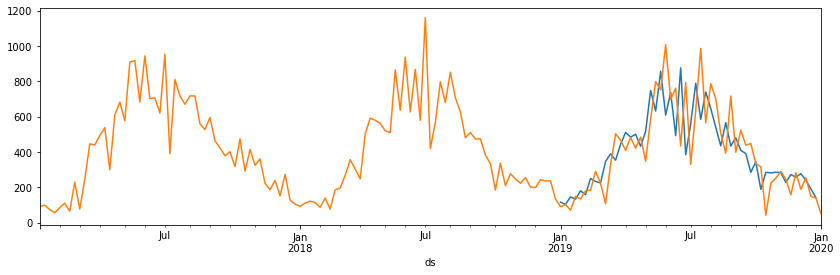

In [219]:
pd.Series(fit.predict(n_periods=52), index=pd.date_range(start="2019-01-01", freq="W", periods=52)).plot()
target_w.plot()

In [210]:
target_m

ds
2017-01-31     355.0
2017-02-28     457.0
2017-03-31    1664.0
2017-04-30    2168.0
2017-05-31    3509.0
2017-06-30    3501.0
2017-07-31    2837.0
2017-08-31    2736.0
2017-09-30    1798.0
2017-10-31    1597.0
2017-11-30    1153.0
2017-12-31     741.0
2018-01-31     492.0
2018-02-28     582.0
2018-03-31    1229.0
2018-04-30    2377.0
2018-05-31    3120.0
2018-06-30    3438.0
2018-07-31    2954.0
2018-08-31    2593.0
2018-09-30    1758.0
2018-10-31    1129.0
2018-11-30     969.0
2018-12-31     889.0
2019-01-31     516.0
2019-02-28     838.0
2019-03-31    1479.0
2019-04-30    1928.0
2019-05-31    3218.0
2019-06-30    2827.0
2019-07-31    3019.0
2019-08-31    2598.0
2019-09-30    1858.0
2019-10-31    1046.0
2019-11-30    1051.0
2019-12-31     785.0
Freq: M, Name: y, dtype: float64